<a href="https://colab.research.google.com/github/AkhilaNacham/MedICat/blob/main/Captions_Traning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# torchvision/torch usually already installed on Colab; pycocotools can help if needed later
!pip install --quiet pycocotools

In [ ]:
import os
import json
import math
import torch
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from google.colab import files

# ========== Edit these paths if you put files elsewhere ==========
ROOT = '/content/drive/MyDrive/MediCat'           # your medicat folder in Drive
FIGURES_DIR = os.path.join(ROOT, 'figures')       # folder containing figure images
JSONL_PATH = os.path.join(ROOT, 'subcaptions_public.jsonl')  # jsonl file you uploaded
OUT_DIR = os.path.join(ROOT, 'aligned_pairs')     # where results (crops + mapping) will be saved
os.makedirs(OUT_DIR, exist_ok=True)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device:", device)
print("Figures folder exists:", os.path.exists(FIGURES_DIR))
print("JSONL path exists:", os.path.exists(JSONL_PATH))

# --------- load detection model (torchvision pre-trained) ------------
def load_detection_model(device=device):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    model.to(device)
    model.eval()
    return model

# --------- function to read jsonl into list/dict ------------
def read_jsonl(path):
    records = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            records.append(json.loads(line))
    return records

# --------- try to robustly match an image filename to a JSON entry ------------
def find_subcaptions_for_image(filename, json_records):
    """
    filename: 'PMC12345_f1.png' or 'PMC12345_f1'
    json_records: list of dicts likely containing fields like 'fig_uri', 'image_id', 'subcaptions'
    """
    fname = os.path.basename(filename)
    name_no_ext = os.path.splitext(fname)[0]

    # 1) exact match on fig_uri or image_id
    for rec in json_records:
        for key in ('fig_uri', 'image_id', 'fig_id', 'uri', 'file'):
            if key in rec:
                val = rec.get(key) or ""
                if isinstance(val, str) and (val == fname or val == name_no_ext or name_no_ext in val):
                    return rec.get('subcaptions') or rec.get('subcaption') or rec.get('captions') or None
    # 2) search fig_uri contains name_no_ext
    for rec in json_records:
        val = rec.get('fig_uri') or rec.get('image_id') or ""
        if isinstance(val, str) and name_no_ext in val:
            return rec.get('subcaptions') or rec.get('subcaption') or rec.get('captions') or None
    # 3) fallback: search in any string field for name_no_ext
    for rec in json_records:
        for k,v in rec.items():
            if isinstance(v, str) and name_no_ext in v:
                return rec.get('subcaptions') or rec.get('subcaption') or rec.get('captions') or None
    return None

# --------- detection + cropping helper ------------
transform = transforms.Compose([transforms.ToTensor()])

def detect_and_crop_one(image_path, model, threshold=0.5, max_boxes=20):
    """
    Returns: orig_image (PIL), boxes (list of [x1,y1,x2,y2]), crops (list of PIL), scores (list)
    """
    img = Image.open(image_path).convert("RGB")
    w, h = img.size
    img_t = transform(img).to(device)

    with torch.no_grad():
        out = model([img_t])[0]

    boxes = out['boxes'].cpu().numpy()
    scores = out['scores'].cpu().numpy()

    # filter by threshold
    keep_idx = np.where(scores >= threshold)[0]
    if len(keep_idx) == 0:
        # fallback: top-k by score
        idxs = np.argsort(-scores)[:max_boxes]
    else:
        idxs = keep_idx

    crops = []
    kept_boxes = []
    kept_scores = []
    for i in idxs:
        x1,y1,x2,y2 = boxes[i].astype(int)
        # clamp
        x1 = max(0, x1); y1 = max(0, y1)
        x2 = min(w, x2); y2 = min(h, y2)
        if x2 - x1 <= 2 or y2 - y1 <= 2:
            continue
        kept_boxes.append([x1,y1,x2,y2])
        kept_scores.append(float(scores[i]))
        crops.append(img.crop((x1,y1,x2,y2)))

    if len(crops) == 0:
        # if nothing detected, return whole image as one crop
        kept_boxes = [[0,0,w,h]]
        crops = [img]
        kept_scores = [1.0]

    # sort top-to-bottom then left-to-right
    sorted_pairs = sorted(zip(kept_boxes, crops, kept_scores), key=lambda bc: (bc[0][1], bc[0][0]))
    boxes_sorted = [p[0] for p in sorted_pairs]
    crops_sorted = [p[1] for p in sorted_pairs]
    scores_sorted = [p[2] for p in sorted_pairs]

    return img, boxes_sorted, crops_sorted, scores_sorted

Device: cuda
Figures folder exists: True
JSONL path exists: True


In [ ]:
# Option to upload directly into the Colab session (not persistent across sessions)
if not os.path.exists(JSONL_PATH):
    print("JSONL not found at expected Drive path:", JSONL_PATH)
    print("Use the file upload tool to upload the jsonl (it will be saved to this Colab VM).")
    uploaded = files.upload()
    if uploaded:
        # save the first uploaded file to the expected JSONL_PATH
        fname = list(uploaded.keys())[0]
        os.makedirs(os.path.dirname(JSONL_PATH), exist_ok=True)
        with open(os.path.join(JSONL_PATH), 'wb') as out_f:
            out_f.write(uploaded[fname])
        print("Uploaded and saved to:", JSONL_PATH)
else:
    print("JSONL already exists:", JSONL_PATH)

JSONL already exists: /content/drive/MyDrive/MediCat/subcaptions_public.jsonl


In [ ]:
records = read_jsonl(JSONL_PATH)
print("Loaded JSONL records:", len(records))
# peek first record
if len(records)>0:
    import pprint
    pprint.pprint(records[0])

Loaded JSONL records: 2118
{'fig_key': 'Figure1',
 'fig_uri': '4-Figure1-1.png',
 'height': 1352,
 'pdf_hash': '81c7347b2d837f84ec3751aeb747fe3a38612c97',
 'subcaptions': {'a': [16,
                       17,
                       18,
                       19,
                       20,
                       21,
                       22,
                       23,
                       24,
                       25,
                       26,
                       27,
                       28,
                       29,
                       30]},
 'subfigures': [{'color': 'yellow',
                 'id': '66e14d81-173c-41c6-b0f8-72f0078bd180',
                 'label': 'a',
                 'points': [[3.2, 0],
                            [3.2, 438.2],
                            [439.3, 438.2],
                            [439.3, 0]]},
                {'color': 'cyan',
                 'id': '3ba2e742-e6dc-4bb6-a29e-01dc3b62371f',
                 'label': 'a',
              

Saving 000f786bf0bb74b19c65777780fc84ead081168a_2-Figure2-1.png to 000f786bf0bb74b19c65777780fc84ead081168a_2-Figure2-1.png
Processing: 000f786bf0bb74b19c65777780fc84ead081168a_2-Figure2-1.png
Detected 2 boxes (threshold=0.35)
No subcaptions found for this image in JSONL.


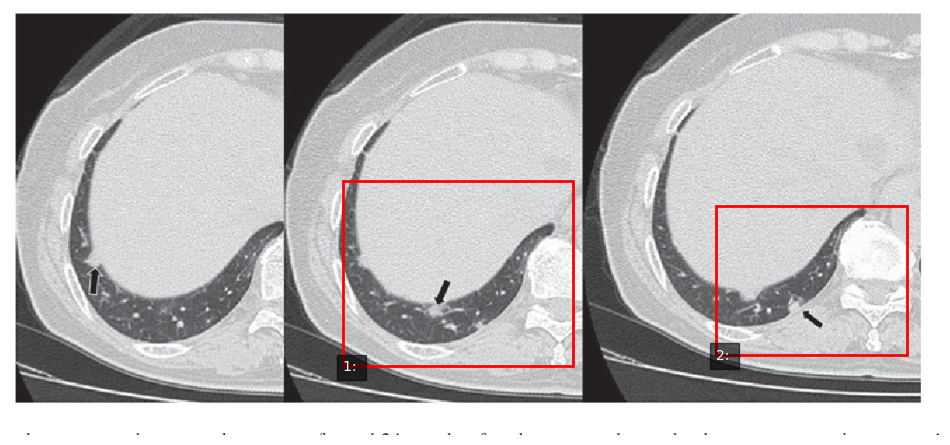

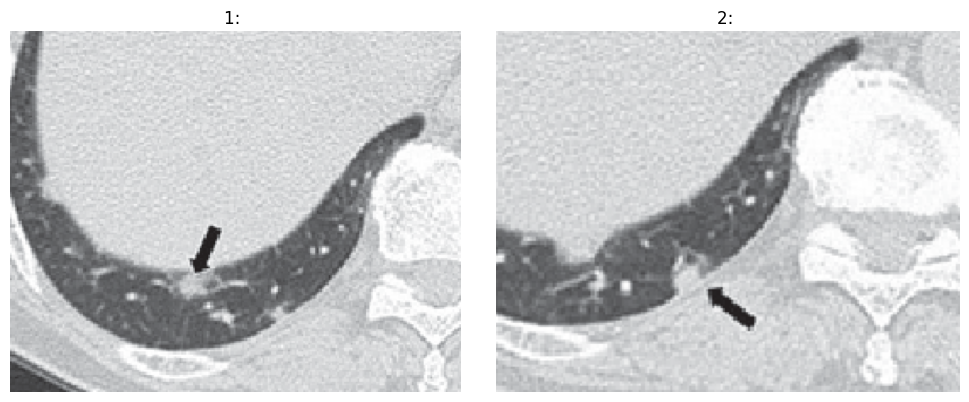

✅ Saved crops + mapping to: /content/drive/MyDrive/MediCat/aligned_pairs/000f786bf0bb74b19c65777780fc84ead081168a_2-Figure2-1


In [ ]:
# Load model (takes a few seconds)
model = load_detection_model(device)

# ---- choose one image to run on ----
# Option B: upload image interactively
from google.colab import files
uploaded = files.upload()
image_name = list(uploaded.keys())[0]
image_path = image_name
print("Processing:", image_path)

# ---- detect and crop ----
THRESH = 0.35   # lower -> more boxes shown; increase to be stricter
orig_img, boxes, crops, scores = detect_and_crop_one(image_path, model, threshold=THRESH)
print(f"Detected {len(boxes)} boxes (threshold={THRESH})")

# ---- find subcaptions from jsonl ----
subcaptions = find_subcaptions_for_image(image_name, records)
if subcaptions is None:
    print("No subcaptions found for this image in JSONL.")
    subcaptions = []
else:
    print(f"Found {len(subcaptions)} subcaptions in JSONL.")

# ---- simple alignment strategy ----
def simple_align(boxes, subcaptions):
    mapping = {}
    n_b = len(boxes)
    n_s = len(subcaptions)
    if n_s == 0:
        for i in range(n_b):
            mapping[i] = ""
        return mapping
    if n_s == 1:
        for i in range(n_b):
            mapping[i] = subcaptions[0]
        return mapping
    # if equal or at least one each -> do order-based mapping
    m = min(n_b, n_s)
    for i in range(m):
        mapping[i] = subcaptions[i]
    # remaining boxes get empty string
    for i in range(m, n_b):
        mapping[i] = ""
    return mapping

mapping = simple_align(boxes, subcaptions)

# ---- visualize original with numbered boxes and labels ----
fig, ax = plt.subplots(1, figsize=(12,12))
ax.imshow(orig_img)
for i,b in enumerate(boxes):
    x1,y1,x2,y2 = b
    rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    label = mapping.get(i, "")
    label_short = (label[:80] + '...') if len(label) > 80 else label
    ax.text(x1, y2+6, f"{i+1}: {label_short}", color='white', fontsize=10, bbox=dict(facecolor='black', alpha=0.6))
plt.axis('off')
plt.show()

# ---- show crops with assigned captions ----
n = len(crops)
cols = min(3, n)
rows = math.ceil(n/cols)
plt.figure(figsize=(5*cols, 4*rows))
for i,c in enumerate(crops):
    plt.subplot(rows, cols, i+1)
    plt.imshow(c)
    cap = mapping.get(i, "")
    plt.title(f"{i+1}: {cap[:120]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# ---- save crops and mapping JSON for this image ----
base_out = os.path.join(OUT_DIR, os.path.splitext(image_name)[0])
os.makedirs(base_out, exist_ok=True)
mappings_out = []

for i, c in enumerate(crops):
    crop_fname = f"crop_{i+1}.png"
    c.save(os.path.join(base_out, crop_fname))

    # make sure box is always a list of ints
    box = boxes[i]
    if hasattr(box, "tolist"):   # if it's a numpy array or torch tensor
        box_list = [int(x) for x in box.tolist()]
    else:  # already a list or tuple
        box_list = [int(x) for x in box]

    mappings_out.append({
        "image": str(image_name),
        "crop_fname": str(crop_fname),
        "box": box_list,
        "subcaption": str(mapping.get(i, ""))
    })

# write mapping json safely
with open(os.path.join(base_out, "mapping.json"), "w", encoding="utf-8") as fw:
    json.dump(mappings_out, fw, ensure_ascii=False, indent=2)

print("✅ Saved crops + mapping to:", base_out)


In [ ]:
# ---- Batch Processing for Many Images ----
import os, json

# WARNING: processing many images can take time. Start small (e.g., N=50).
N = 50   # change to how many images you want to process
THRESH = 0.35
model = load_detection_model(device)

images = sorted([f for f in os.listdir(FIGURES_DIR) if f.lower().endswith(('.png','.jpg','.jpeg'))])
count = 0

for image_name in images[:N]:
    image_path = os.path.join(FIGURES_DIR, image_name)
    try:
        # run detection
        orig_img, boxes, crops, scores = detect_and_crop_one(image_path, model, threshold=THRESH)

        # find subcaptions from JSONL
        subcaptions = find_subcaptions_for_image(image_name, records) or []
        mapping = simple_align(boxes, subcaptions)

        # prepare output directory
        base_out = os.path.join(OUT_DIR, os.path.splitext(image_name)[0])
        os.makedirs(base_out, exist_ok=True)
        mappings_out = []

        # save crops and mapping
        for i, c in enumerate(crops):
            crop_fname = f"crop_{i+1}.png"
            c.save(os.path.join(base_out, crop_fname))

            # ✅ FIX: ensure box coordinates are Python ints
            box = boxes[i]
            if hasattr(box, "tolist"):   # numpy array or tensor
                box_list = [int(x) for x in box.tolist()]
            else:  # already list or tuple
                box_list = [int(x) for x in box]

            mappings_out.append({
                "image": str(image_name),
                "crop_fname": str(crop_fname),
                "box": box_list,
                "subcaption": str(mapping.get(i, ""))
            })

        # write mapping.json
        with open(os.path.join(base_out, "mapping.json"), "w", encoding="utf-8") as fw:
            json.dump(mappings_out, fw, ensure_ascii=False, indent=2)

        count += 1
        if count % 10 == 0:
            print("Processed", count, "images")

    except Exception as e:
        print("Failed on", image_name, ":", str(e))

print("Done. Processed:", count)


Processed 10 images
Processed 20 images
Processed 30 images
Processed 40 images
Processed 50 images
Done. Processed: 50
